# Part 1 (Decision Trees)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Entropy Calculation

In [2]:
def  entropy(y):
    """
    y - Numpy array for which entropy need to be calculated
    
    """
    # No more splits
    if (len(y) == 0):
        return 0
    
    p1 = np.sum(y==1)/len(y) # Purchased
    p0 = 1 - p1 # Not Purchased
    
    # If  there exist a pure split, then there exist only one subset (either yes or no). So one probability will be 0.
    # If proability is 0, log(0) is not defined. Hence for calculation purpose 0 is returned as the entropy
    if p1 == 0 or p0 == 0:
        return 0
    entropy = - p1 * np.log2(p1) - p0 * np.log2(p0)
    
    return entropy

### Gini Index calculation

In [3]:
def  GI(y):
    """
    y - Numpy array for which Gini impurity need to be calculated
    
    """
    # No more splits
    if (len(y) == 0):
        return 0
    
    p1 = np.sum(y==1)/len(y) # Purchased
    p0 = 1 - p1 # Not Purchased
    P = p1**2 + p0**2

    GI = 1 - P
    
    return GI

### Building decision tree
- **Stopping criteria**
    1. When there is no impurity at all split.
    1. When reaching a maximum specified depth. 
    1. When improvement in purity score is below certain threshold.
    1. When Number of examples in a node is below a threshold.
- I will be using **1 & 2** 

In [4]:
class Node():
    def __init__(self, threshold=None, feature_idx=None, children=None, left=None, right=None, value=None):
        
        # Decision Node
        #self.parent = parent
        self.threshold = threshold
        self.feature_index = feature_idx
        self.left = left
        self.right = right
        
        # Leaf Node
        self.value = value # Majority label

In [5]:
class DecisionTree():
    def __init__(self, data, n, max_depth, cont_indx=[], criteria=GI):
        self.n = n
        self.max_depth = max_depth
        self.cont_indx = cont_indx
        self.criteria=criteria
        self.root = None
        
    
    def information_gain(self, Data, feature, thresh=1):
        """
        Data: matrix of  Remaininf data to be splitted with 3 features and labels
        feature: index of features based on which split is done:  possible values 0,1,2

        """
        if len(Data) == 0:
            return None

        # greater values are at left node
        LeftNode_index  = np.where(Data[: , feature] >= thresh)[0] # Using greater than equal for generality
        RightNode_index = np.where(Data[: , feature] < thresh)[0] # Same reason for usage of less than


        LeftNode = Data[LeftNode_index, -1] # Empty data frame if no examples on right node
        RightNode = Data[RightNode_index, -1] # Empty data frame if no examples on right node

        # Main node entropy
        RootNode = Data[:, -1]
        E_root = self.criteria(RootNode)

        # Calculate entropy for left and right nodes.
        # Below subsets may/may'nt contain both edible and non edible mushrooms
        E_L = self.criteria(LeftNode) # feature value = 1
        E_R = self.criteria(RightNode) # feature value = 0

        # Weights, i.e subset proportion for left and right nodes
        w_L = len(LeftNode)/len(Data)
        w_R = len(RightNode)/len(Data)

        # Information gain
#         print(f"Root: {E_root:.3f}, W_L :{w_L:.3f}, E_L: {E_L:.3f}, w_R: {w_R:.3f}, E_R: {E_R:.3f}")
        IG = E_root - (w_L * E_L) - (w_R * E_R)

        return IG, LeftNode_index, RightNode_index
    
    def get_threshold(self, data, feature): 
        """
        data: numpy matrix (2-d array)
        feature: index of feature for which gini table is to be calculated
        
        ---
        Creation of weighted gini table
        ---
        returns list containing:
        - threshold
        - information gain with that threshold
        """
        col_values = data[:, feature].copy()

        col_values = np.unique(col_values)
        col_values.sort()

        entries = (col_values + np.concatenate([col_values[1:], np.array([0])])) / 2 

        Max_entry = [entries[0], self.information_gain(data, feature, entries[0])[0]]
    
        # We have to find threshold with maximum IG
        for i in entries[1:]:
            if self.information_gain(data, feature, i)[0] > Max_entry[1]:
                Max_entry = [i, self.information_gain(data, feature, i)[0]] #
        return Max_entry
    
    def get_best_split(self, data, n):
        """
        data -> Elements in the current root node
        n -> Number of features in dataframe

        returns list containing: 
        Best split's Information gain value
        Best split's left node index
        Best split's right node index
        Best split feature number

        """
        Max_IG = [-1,[],[], None] # information gain, leftNodes IDx, RightNodes Idx,
                                            # Feature with max IG

        for i in range(self.n):
            if i in self.cont_indx:
                thresh = self.get_threshold(data, i)[0]
            else:
                thresh=1

            IG, leftNode_idx, rightNode_idx = self.information_gain(data, i, thresh) 
            if IG > Max_IG[0]:
                Max_IG = [IG, leftNode_idx, rightNode_idx, i, thresh]
        return Max_IG
    
    def calc_leaf_majority(self, data):
        values = data[:, -1]
#         print(np.argmax(np.bincount(values)))
        return np.argmax(np.bincount(values))
    
    def build_tree(self, data, current_depth):
        #print(current_depth)
        if current_depth <= self.max_depth:
            ig, leftNode_idx, rightNode_idx, feature, thresh = self.get_best_split(data, self.n)
#             print(ig, leftNode_idx.shape, rightNode_idx.shape, "data:", data.shape, f"Bincount-left: {np.bincount(data[leftNode_idx, -1])}", f"Bincount-right: {np.bincount(data[rightNode_idx, -1])}")
#             print("-----------------------------------------------------")
            if ig > 0: # cannot have it as >= 0, because empty subset is possible
                leftNodeData = data[leftNode_idx, :]
                rightNodeData = data[rightNode_idx, :]
                
                # Decision Node
                node = Node(threshold=thresh)
                node.left = self.build_tree(leftNodeData, current_depth+1) 
                node.right = self.build_tree(rightNodeData,current_depth+1) 
                node.feature_index=feature
                return node
        else:
            print("Depth reached")
            
        # Leaf node
        node = Node()
        node.value = self.calc_leaf_majority(data)
        return node
        
    def predict(self, data):
        prediction = []
        for i in data:
            prediction.append(self.make_prediction(self.root, i))
        return np.array(prediction)
        
        
    def make_prediction(self, tree, Input):
        if tree.value != None:
#             print("none")
            return tree.value
        else:
#             print(tree.feature_index, tree.threshold, Input[tree.feature_index])
            if  Input[tree.feature_index] >= tree.threshold:
#                 print("left")
                prediction = self.make_prediction(tree.left, Input)
            else:
#                 print("right")
                prediction = self.make_prediction(tree.right, Input)
            return prediction
    # inorder traversal
    def display(self,tree):
        if tree.value != None:
            #print(f"\t\t\tleaf value: {tree.value}")
            return
        self.display(tree.left)
        print(f"feature: {tree.feature_index}, threshold: {tree.threshold}")
        self.display(tree.right)
        return
        
        

In [6]:
data = pd.read_csv('classification.csv')
# data.info()
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1].values, data.iloc[:,-1].values, 
                                                   train_size=0.8, random_state=1)

### Q1 (Gini Index values)
- Note: Increasing max depth might increases accuracy

In [7]:
Train = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
classifier1 = DecisionTree(Train, n=2, max_depth=3, cont_indx=[0,1], criteria=GI)
print(classifier1.get_threshold(data.values,0))
print(classifier1.get_threshold(data.values,1))

[42.5, 0.1905972635392829]
[89500.0, 0.13182194055944052]


### Q2 (Decision tree classifier)
- Compute mode while prediction, if the DT weren't able to purely split the data samples at leaf node

##### Dataset 1

In [8]:
classifier1.root = classifier1.build_tree(Train,current_depth=0)

Depth reached
Depth reached
Depth reached
Depth reached
Depth reached
Depth reached
Depth reached
Depth reached
Depth reached
Depth reached


In [9]:
# Inorder traversal
classifier1.display(classifier1.root)

feature: 1, threshold: 48000.0
feature: 1, threshold: 41500.0
feature: 0, threshold: 46.5
feature: 1, threshold: 85000.0
feature: 1, threshold: 52000.0
feature: 1, threshold: 22500.0
feature: 0, threshold: 44.5
feature: 1, threshold: 118500.0
feature: 1, threshold: 112500.0
feature: 1, threshold: 90500.0
feature: 1, threshold: 83500.0
feature: 0, threshold: 36.5


In [10]:
predictions = classifier1.predict(X_test)
(y_test == predictions).mean()

0.8375

##### Dataset 2

In [11]:
data2 = np.load("data.npy")

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(data2[:, :-1], data2[:, -1], train_size=0.8, random_state=1)
# X_train.shape, y_train.shape

In [13]:
# Train = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
Dmodel2 = DecisionTree(data2, n=3, max_depth=5, criteria=entropy)
Dmodel2.root = Dmodel2.build_tree(data2,current_depth=0)
Dmodel2.display(Dmodel2.root)

feature: 2, threshold: 1
feature: 0, threshold: 1
feature: 1, threshold: 1
feature: 0, threshold: 1


#### Toy test data

In [14]:
X_test = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_test = np.array([1,1,0,0,1,0,0,1,1,0])

In [15]:
(Dmodel2.predict(X_test) == y_test).mean()

0.9

In [16]:
(Dmodel2.predict(X_test))

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0])

In [17]:
y_test

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0])

# Part 2 (Gradient Descent for Linear regression from scratch)

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
def generate_data():
    noise = np.random.normal(0,70, (1000)) *  np.random.uniform(-10,10,1)
    x = np.arange(1000)
    # y = mx + c + noise
    y =  x * 0.8 * np.random.rand() + 0 + noise 
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    data = np.concatenate([x,y], axis=1)
    return data

In [20]:
np.random.seed(1)
data = generate_data()
data.shape

(1000, 2)

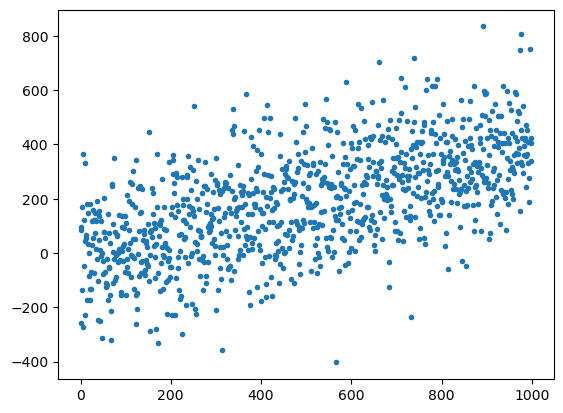

In [21]:
plt.plot(data[:, 0], data[:, 1], linestyle="", marker='.')

## Split

In [22]:
def split(data, seed):
    np.random.seed(seed)
    np.random.shuffle(data)
    train_size = int(0.8 * len(data))
    train = data[ : train_size, : ]
    test = data[train_size: , :]
    return train[:, 0], test[:,0] ,train[:, 1], test[:,1]

In [23]:
train_X, test_X, train_y, test_y = split(data, 42)

In [24]:
train_X.shape, train_y.shape

((800,), (800,))

In [25]:
test_X.shape, test_y.shape

((200,), (200,))

## Regression model

### From scratch

In [26]:
class Model:
    def __init__(self, in_features, alpha):
        self.w = np.random.rand(in_features) 
        self.b = np.random.rand(1) 
        self.alpha = alpha
    def forward(self, x):
        result =  x * (self.w) + self.b 
        return result
    
    def update(self, x, y):
        dJ_dw = np.sum((self.w * x - y)*(x))
        dJ_db = np.sum((self.w * x - y))
        self.w = self.w - self.alpha * dJ_dw
        self.b = self.b - self.alpha * dJ_db



In [27]:
def error(pred, y):
    return (np.mean((pred - y) ** 2))

In [28]:
def train(model, epoch, x, y):
    for i in range(epoch):
        pred = model.forward(x)
        cost = error(pred, y)
        model.update(x,y)
        print(f'Epoch: {i+1}, loss: {cost}')

In [29]:
np.random.seed(1)
model = Model(1, 0.00000000000001)
train(model, 150, train_X, train_y)

Epoch: 1, loss: 24019.98381774881
Epoch: 2, loss: 24019.980853152578
Epoch: 3, loss: 24019.977888572048
Epoch: 4, loss: 24019.97492400724
Epoch: 5, loss: 24019.971959458144
Epoch: 6, loss: 24019.968994924762
Epoch: 7, loss: 24019.966030407093
Epoch: 8, loss: 24019.96306590513
Epoch: 9, loss: 24019.960101418885
Epoch: 10, loss: 24019.95713694836
Epoch: 11, loss: 24019.954172493537
Epoch: 12, loss: 24019.951208054434
Epoch: 13, loss: 24019.94824363104
Epoch: 14, loss: 24019.94527922336
Epoch: 15, loss: 24019.94231483139
Epoch: 16, loss: 24019.939350455134
Epoch: 17, loss: 24019.936386094596
Epoch: 18, loss: 24019.93342174976
Epoch: 19, loss: 24019.930457420647
Epoch: 20, loss: 24019.927493107236
Epoch: 21, loss: 24019.924528809544
Epoch: 22, loss: 24019.921564527565
Epoch: 23, loss: 24019.918600261295
Epoch: 24, loss: 24019.91563601073
Epoch: 25, loss: 24019.912671775885
Epoch: 26, loss: 24019.909707556748
Epoch: 27, loss: 24019.90674335333
Epoch: 28, loss: 24019.903779165616
Epoch: 29, 

### Evaluation

In [30]:
def visual(x, y, pred):
    plt.plot(x, y, linestyle="", c='r', marker='.')
    plt.plot(x, pred, linestyle="-", c='g')
    plt.show()

In [31]:
predict1 = model.forward(test_X)
print(f'r2 score: {r2_score(y_true=test_y, y_pred=predict1)}')
print(f'MSE: {mean_squared_error(predict1, test_y)}')
print(f'MAE: {mean_absolute_error(predict1, test_y)}')

r2 score: 0.3318442885454065
MSE: 26060.421781173944
MAE: 125.49687992002528


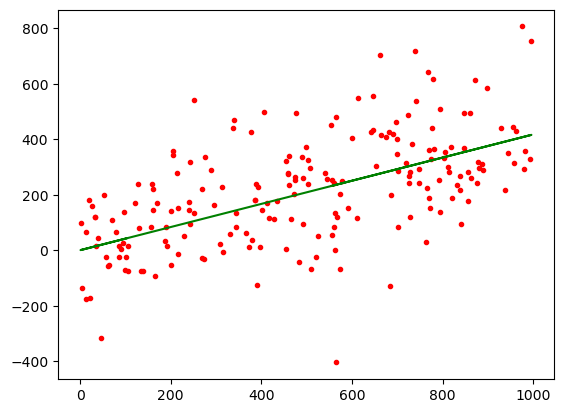

In [32]:
visual(test_X, test_y, predict1)

## Sklearn model

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
reg = LinearRegression()
model2 = reg.fit(train_X.reshape(-1,1), train_y)

In [35]:
predict2 = model2.predict(test_X.reshape(-1,1))
print(f'r2 score: {r2_score( y_true=test_y, y_pred=predict2)}')
print(f'MSE: {mean_squared_error(predict2, test_y)}')
print(f'MAE: {mean_absolute_error(predict2, test_y)}')

r2 score: 0.30130472584498436
MSE: 27251.572094404026
MAE: 127.71450470056554


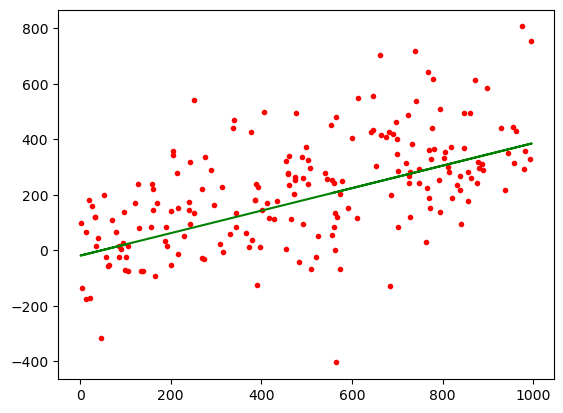

In [36]:
visual(test_X, test_y, predict2)

### Observations
- Both regression line are same. Reason being, data is not that complicated hence even my from `scratch model` performs equally well to sklearn's model.